In [85]:
import pandas as pd
import plotly.express as px
import numpy as np
import nltk
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Set pandas display options
pd.options.display.max_colwidth = 10000
pd.set_option('display.max_rows', 1000)
pd.options.mode.chained_assignment = None


In [86]:
# Load tweets into dataframe. Drop the state column.
file = 'cleantweets.csv'
df = pd.read_csv(file, sep=';').dropna(subset=['state'])
df['text'] = df['text'].str.lower()

# Drop the tweets that are not formatted correctly (15 tweets dropped)
df = df.loc[~(df['id'].str.isdigit() == False)]

/var/folders/bk/vn3d52k94dlggw29lr3_w3wr0000gn/T/ipykernel_85645/1596480348.py:3: DtypeWarning:

Columns (0,3,5) have mixed types. Specify dtype option on import or set low_memory=False.



The number of tweets in the dataframe:

In [87]:
# Total tweets in dataframe
print(f"Tweet total: {len(df)}")

Tweet total: 9455538


In [88]:
# Assign a tweet to a candidate, both, or neither.
df['candidate'] = np.where(
        (df['text'].str.contains('trump') == True) & (df['text'].str.contains('biden') == True), 
        'Trump_Biden', 'NA')
df['candidate'] = np.where(
        (df['text'].str.contains('trump') == True) & (df['text'].str.contains('biden') == False), 
        'Trump', df['candidate'])
df['candidate'] = np.where(
        (df['text'].str.contains('biden') == True) & (df['text'].str.contains('trump') == False), 
        'Biden', df['candidate'])

Tweets relating to each candidate

In [89]:
# Print the tweets for each candidate.
print(f"Trump/Biden tweets: {len(df[df['candidate'] == 'Trump_Biden'])}")
print(f"Trump tweets: {len(df[df['candidate'] == 'Trump'])}")
print(f"Biden tweets: {len(df[df['candidate'] == 'Biden'])}")
print(f"Unrelated tweets: {len(df[df['candidate'] == 'NA'])}")

Trump/Biden tweets: 802761
Trump tweets: 3710694
Biden tweets: 1889374
Unrelated tweets: 3052709


In [90]:
# Tweets for Biden and Trump from each state.

df2 = df.loc[(df['candidate'] != 'NA') & (df['candidate'] != 'Trump_Biden')]
state_df = df2.groupby(['state']).size().sort_values(ascending=False).rename('Tweets_per_state').reset_index()
state_df = state_df.merge(df2.groupby(['state', 'candidate']).size().rename('Tweets_per_candidate').reset_index())
state_df = state_df[~(state_df['candidate'] == 'NA')]

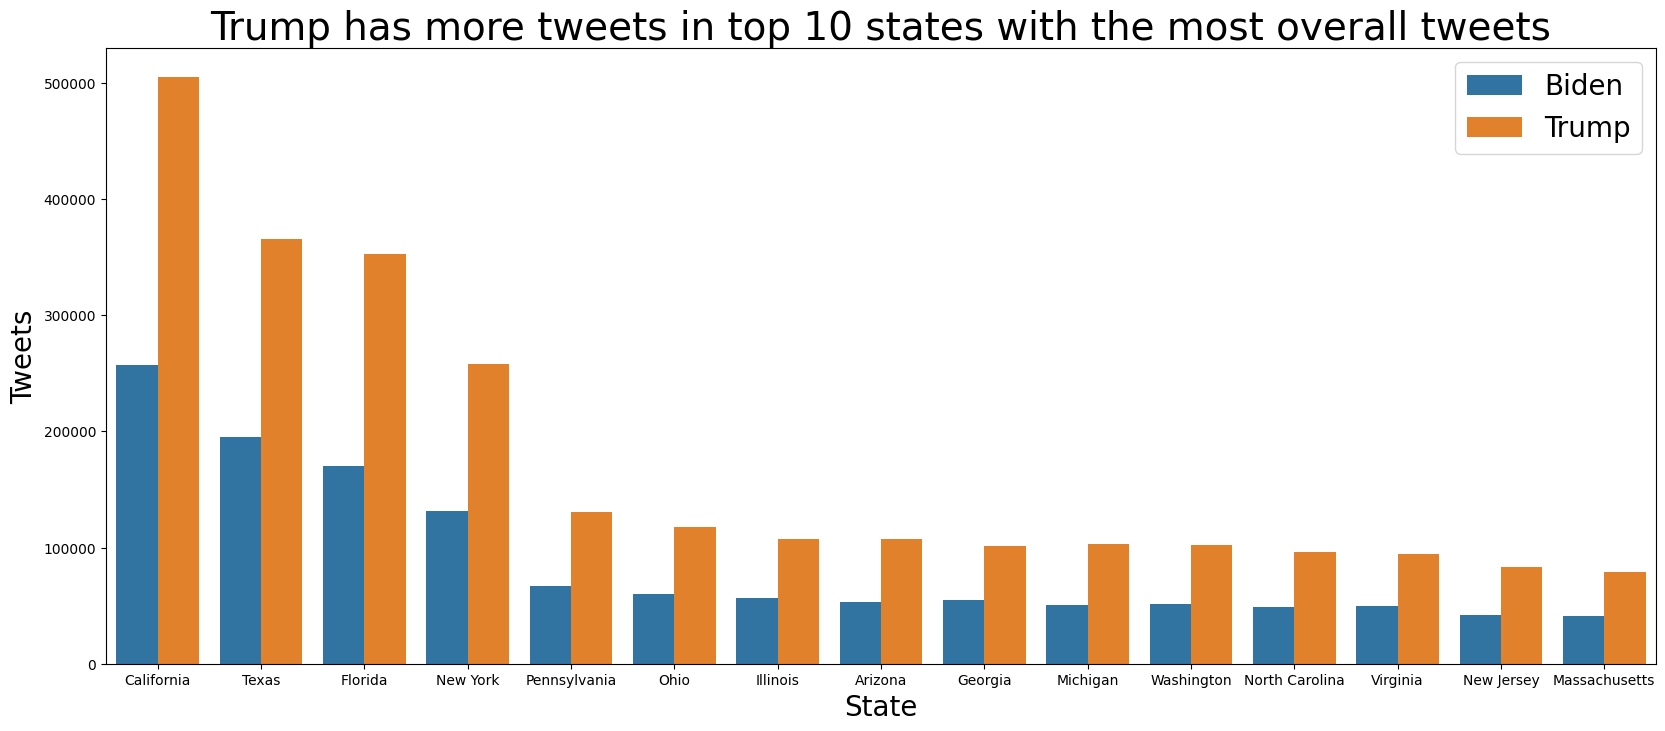

In [91]:
# Plot the tweets for each candidate in the top 10 states with the most tweets overall.

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=state_df.head(30),x='state', y='Tweets_per_candidate',hue='candidate')
plt.title('Trump has more tweets in top 10 states with the most overall tweets', fontsize=28)
plt.legend(loc=1, prop={'size': 20})
ax.set_ylabel('Tweets', fontsize=20)
ax.set_xlabel('State', fontsize=20)
plt.show()

# Vader sentiment analysis

In [92]:
def sentimentVerdict(sentiment):
    if sentiment['compound'] >= 0.05:
        return "Positive"
    elif sentiment['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df2['sentiment_scores'] = df2['text'].apply(lambda x: sid.polarity_scores(x))
df2['sentiment'] = df2['sentiment_scores'].apply(lambda x: sentimentVerdict(x))

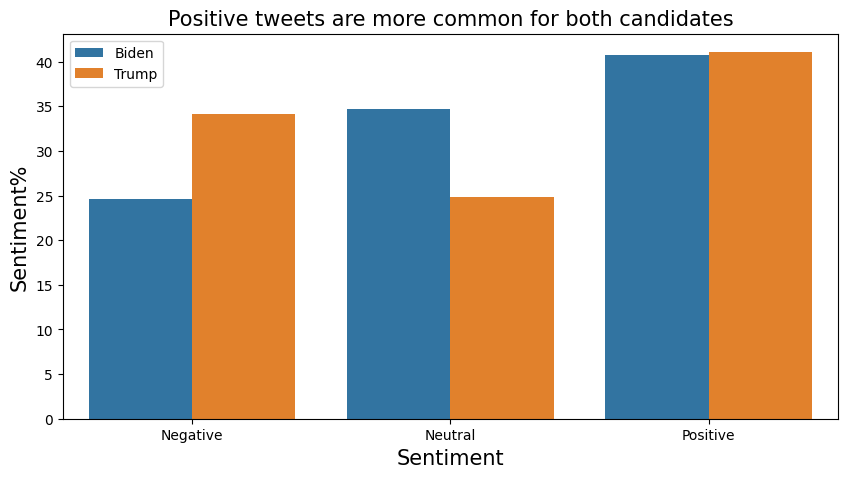

In [93]:
# Create a small dataframe for plotting sentiment
sent_df = df2.groupby(['candidate', 'sentiment']).size().rename('total_sent_per_candidate').reset_index()
sent_df = sent_df.merge(df2.groupby(['candidate']).size().rename('total_tweets_per_candidate').reset_index())
sent_df['sent_percent'] = sent_df['total_sent_per_candidate'] / sent_df['total_tweets_per_candidate'] * 100

# Plot the sentiment percentage for each candidate.
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=sent_df, x='sentiment', y='sent_percent' ,hue='candidate')
plt.title('Positive tweets are more common for both candidates', fontsize=15)
plt.legend(loc=0, prop={'size': 10})
ax.set_ylabel('Sentiment%', fontsize=15)
ax.set_xlabel('Sentiment', fontsize=15)
plt.show()

# Sentiment % pos neg

In [94]:
# Create a datafarame for predicting election results based on sentiment analysis.
overview_df = pd.DataFrame()

# Get the unique states
overview_df['state'] = df2.state.unique()

#Total number of tweets
overview_df = overview_df.merge(df2.groupby('state')['id'].count().reset_index(name="total_tweets"), on='state', how='left')

#Number of tweets for Trump
overview_df = overview_df.merge(df2[(df2['candidate'] == 'Trump') &
                                 (df2['sentiment'] == 'Positive')].groupby('state')['id'].count().reset_index(name="Trump_P"), on='state', how='left')
overview_df = overview_df.merge(df2[(df2['candidate'] == 'Trump') &
                                 (df2['sentiment'] == 'Negative')].groupby('state')['id'].count().reset_index(name="Trump_N"), on='state', how='left')
overview_df = overview_df.merge(df2[(df2['candidate'] == 'Trump') &
                                 (df2['sentiment'] == 'Neutral')].groupby('state')['id'].count().reset_index(name="Trump_Na"), on='state', how='left')
#Number of tweets for Biden
overview_df = overview_df.merge(df2[(df2['candidate'] == 'Biden') &
                                 (df2['sentiment'] == 'Positive')].groupby('state')['id'].count().reset_index(name="Biden_P"), on='state', how='left')
overview_df = overview_df.merge(df2[(df2['candidate'] == 'Biden') &
                                 (df2['sentiment'] == 'Negative')].groupby('state')['id'].count().reset_index(name="Biden_N"), on='state', how='left')
overview_df = overview_df.merge(df2[(df2['candidate'] == 'Biden') &
                                 (df2['sentiment'] == 'Neutral')].groupby('state')['id'].count().reset_index(name="Biden_Na"), on='state', how='left')



In [95]:
# Positive tweets perc of total number of tweets
overview_df['Trump_P_perc_total'] = overview_df['Trump_P'] / overview_df['total_tweets']
overview_df['Biden_P_perc_total'] = overview_df['Biden_P'] / overview_df['total_tweets']

# Positive tweets perc of number of tweets of each candidate
overview_df['Trump_P_perc_only'] = overview_df['Trump_P'] / (overview_df['Trump_P'] + overview_df['Trump_N'] + overview_df['Trump_Na'])
overview_df['Biden_P_perc_only'] = overview_df['Biden_P'] / (overview_df['Biden_P'] + overview_df['Biden_N'] + overview_df['Biden_Na'])


In [96]:
# States codes for the map figure
stateMapping = {}
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New York', 'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
stateCodes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
stateMapping['state']= states
stateMapping['state_code'] = stateCodes 
overview_df = overview_df.merge(pd.DataFrame.from_dict(stateMapping), on='state', how='left')


# 2020 Election Real Result

In [97]:
# Read in the final results of the election.
real_result =  pd.read_csv('finalResult.csv', lineterminator='\n')
real_result = real_result.drop(['State'], axis=1)
real_result = real_result.rename(columns={'newST': 'state_code'})
real_result['winner'] = real_result['won'].str.replace("T", "Trump").replace("B", "Biden")

# Make Biden's color blue.
d = {0: 2, 2: 0}
real_result = real_result.rename(d).sort_index()

#Drop the unnecessary row
real_result = real_result.drop([52])

# Join actual election results with overview_df.
overview_df = overview_df.merge(real_result[["state_code", "winner"]], on='state_code', how='left')

In [98]:
# Print the election map showing the actual results of the 2020 US presidential election.
fig = px.choropleth(real_result, 
                    color='winner', 
                    locations="state_code", 
                    locationmode="USA-states", 
                    scope="usa",
                    title=f"2020 Actual U.S. Presidential Election Map")

fig.show()

### Method 1: Predicted election accuracy for winner candidate with highest respective positive tweets to each candidate

In [99]:
# Plot the results of the election based on method 1: Winner is candidate with highest respective positive tweets.
overview_df['predicted_winner'] = np.where(overview_df['Trump_P_perc_only'] > overview_df['Biden_P_perc_only'], 'Trump', 'Biden')

# Get the predicted election accutacy.
overview_df["correct"] = np.where(overview_df["predicted_winner"] == overview_df["winner"], 1, 0)
accuracy = np.sum(overview_df["correct"]) / len(overview_df["correct"])

fig = px.choropleth(
    overview_df, 
    color='predicted_winner', 
    locations='state_code', 
    locationmode="USA-states", 
    scope="usa",
    title=f"2020 Predicted U.S. Presidential Election Map <br><sup>Accuracy {round(accuracy,2)*100}%</sup>")

fig.show()

### Method 2:  Predicted election accuracy for winner candidate with highest positive and highest of opposite candidate negative

In [100]:
# Plot the results of the election based on method 2:
overview_df['predicted_winner'] = np.where(overview_df["Trump_P"] + overview_df["Biden_N"] > 
                                           overview_df["Biden_P"] + overview_df["Trump_N"], 'Trump', 'Biden')
overview_df["correct"] = np.where(overview_df["predicted_winner"] == overview_df["winner"], 1, 0)
accuracy = np.sum(overview_df["correct"]) / len(overview_df["correct"])
fig = px.choropleth(overview_df, 
                    color='predicted_winner', 
                    locations='state_code', 
                    locationmode="USA-states", 
                    scope="usa", 
                    title=f"2020 Predicted U.S. Presidential Election Map <br><sup>Accuracy {round(accuracy,2)* 100}%</sup>")
fig.show()

### Method 3: Predicted election accuracy for winner candidate with lowest respective negative tweets

In [101]:
# Plot the results of the election based on method 3:

# Negative tweets perc of total number of tweets
overview_df['Trump_N_perc_total'] = overview_df['Trump_N'] / overview_df['total_tweets']
overview_df['Biden_N_perc_total'] = overview_df['Biden_N'] / overview_df['total_tweets']

# Negative tweets perc of numver of tweets of each candidate
overview_df['Trump_N_perc_only'] = overview_df['Trump_N'] / (overview_df['Trump_P'] + overview_df['Trump_N'] + overview_df['Trump_Na'])
overview_df['Biden_N_perc_only'] = overview_df['Biden_N'] / (overview_df['Biden_P'] + overview_df['Biden_N'] + overview_df['Biden_Na'])

overview_df['predicted_winner'] = np.where(overview_df["Trump_N_perc_only"] > 
                                            overview_df["Biden_N_perc_only"], 'Biden', 'Trump')


overview_df["correct"] = np.where(overview_df["predicted_winner"] == overview_df["winner"], 1, 0)
accuracy = np.sum(overview_df["correct"]) / len(overview_df["correct"])


fig = px.choropleth(overview_df, 
                    color='predicted_winner', 
                    locations='state_code', 
                    locationmode="USA-states", 
                    scope="usa", 
                    title=f"2020 Predicted U.S. Presidential Election Map <br><sup>Accuracy {round(accuracy,1)*100}%</sup>")

fig.show()




# Real elections with swing states

In [102]:
"""df3 =  pd.read_csv('finalResult.csv', lineterminator='\n')
df3 = df3.drop(['State'], axis=1)
df3 = df3.rename(columns={'newST': 'State'})
df3['Won election'] = df3['won'].str.replace("T", "Trump").replace("B", "Biden")
#unnessarcy row
df3 = df3.drop([52])"""

#we consider it a swing state if during the real election there was a difference of less than 5 %
#Arizona -> biden, florida -> Trump, Georiga -> Biden, Michigan -> Biden, Nevada -> Biden, North carolina -> Trump
#, Pennysilvina _ biden, wisconsin -> Biden
real_result['Swing state to'] = real_result['winner']
real_result.loc[real_result['state_code'] == 'AZ' ,['Swing state to']] = 'Swing state to Biden'
real_result.loc[real_result['state_code'] == 'GA' ,['Swing state to']] = 'Swing state to Biden'
real_result.loc[real_result['state_code'] == 'MI' ,['Swing state to']] = 'Swing state to Biden'
real_result.loc[real_result['state_code'] == 'NV' ,['Swing state to']] = 'Swing state to Biden'
real_result.loc[real_result['state_code'] == 'PA' ,['Swing state to']] = 'Swing state to Biden'
real_result.loc[real_result['state_code'] == 'WI' ,['Swing state to']] = 'Swing state to Biden'
real_result.loc[real_result['state_code'] == 'FL' ,['Swing state to']] = 'Swing state to Trump'
real_result.loc[real_result['state_code'] == 'NC' ,['Swing state to']] = 'Swing state to Trump'

In [103]:
fig = px.choropleth(locations=real_result['state_code'], 
                    locationmode="USA-states",
                    color=real_result['Swing state to'],
                    color_discrete_map={'Trump':'rgb(200, 0, 0)', 'Swing state to Trump': 'rgb(300, 40, 40)', 'Biden':'rgb(0, 0, 200)', 'Swing state to Biden': 'rgb(40, 40, 300)'},scope="usa"
                   )

fig.update_layout(legend={'title_text':'' })
fig.show()

# Our results with swing states

Method 1 has the highest accuracy among the others. So, we are going to continue with the result of Method 1 from now on.

In [104]:
overview_df['predicted_winner'] = np.where(overview_df['Trump_P_perc_only'] > overview_df['Biden_P_perc_only'], 'Trump', 'Biden')
overview_df['predicted_winner_swing'] = overview_df['predicted_winner']
overview_df['predicted_winner_swing'].loc[indices_trump] = 'Swing state to Trump'
overview_df['predicted_winner_swing'].loc[indices_biden] = 'Swing state to Biden'


In [106]:
fig = px.choropleth(locations=overview_df['state_code'], 
                    locationmode="USA-states",
                    color=overview_df['predicted_winner_swing'],
                    color_discrete_map={'Trump':'rgb(200, 0, 0)', 'Swing state to Trump': 'rgb(300, 40, 40)', 'Biden':'rgb(0, 0, 200)', 'Swing state to Biden': 'rgb(40, 40, 300)'},scope="usa",
                    title=f"2020 Actual U.S. Presidential Election Map (Swing States)")

fig.show()

# Results in our election

In [107]:
stateElectoral = {}

states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 
          'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 
          'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
          'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 
          'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 
          'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 
          'New York', 'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 
          'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 
          'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 
          'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

Electoral_votes = [9, 3, 11, 6, 55, 
                   9, 7, 3, 29, 16, 
                   4, 4, 20, 11, 6, 
                   6, 8, 8, 4, 10, 
                   11, 16, 10, 6, 10, 
                   3, 5, 6, 4, 14, 
                   5, 29, 15, 3, 18, 
                   7, 7, 20, 4, 9, 
                   3, 11, 38, 6, 3, 
                   13, 12, 5, 10, 3]
stateElectoral['state'] =  states

stateElectoral['Electoral votes'] = Electoral_votes
stateElectoral_df = pd.DataFrame.from_dict(stateElectoral)

overview_df = overview_df.merge(pd.DataFrame.from_dict(stateElectoral), on='state', how='left')

,state,total_tweets,Trump_P,Trump_N,Trump_Na,Biden_P,Biden_N,Biden_Na,Trump_P_perc_total,Biden_P_perc_total,...,state_code,winner,predicted_winner,correct,Trump_N_perc_total,Biden_N_perc_total,Trump_N_perc_only,Biden_N_perc_only,predicted_winner_swing,Electoral votes
0,Pennsylvania,196670,52686,44664,32826,27436,16235,22823,0.267890,0.139503,...,PA,Biden,Biden,1,0.227101,0.082549,0.343105,0.244157,Biden,20.0
1,New Jersey,125193,33783,28596,20680,17168,10393,14573,0.269847,0.137132,...,NJ,Biden,Biden,1,0.228415,0.083016,0.344285,0.246665,Swing state to Biden,14.0
2,Michigan,153582,40696,36362,25681,20913,12336,17594,0.264979,0.136168,...,MI,Biden,Biden,1,0.236760,0.080322,0.353926,0.242629,Biden,16.0
3,Nevada,67763,18979,15187,11123,8968,5719,7787,0.280079,0.132344,...,NV,Biden,Trump,1,0.224119,0.084397,0.335335,0.254472,Trump,6.0
4,Florida,522636,153555,111233,87552,65108,45540,59648,0.293809,0.124576,...,FL,Trump,Trump,0,0.212831,0.087135,0.315698,0.267417,Trump,29.0
5,California,762340,198997,180620,125280,109793,58759,88891,0.261034,0.144021,...,CA,Biden,Biden,1,0.236928,0.077077,0.357736,0.228241,Biden,55.0
6,District of Columbia,92046,23529,20696,15253,14396,6969,11203,0.255622,0.156400,...,NaN,NaN,Biden,0,0.224844,0.075712,0.347961,0.213983,Biden,NaN
7,South Carolina,70770,20602,14844,11572,9040,6371,8341,0.291112,0.127738,...,SC,Trump,Trump,0,0.209750,0.090024,0.315709,0.268230,Trump,9.0
8,New York,389320,101574,91989,64100,56063,30460,45134,0.260901,0.144002,...,NM,Biden,Biden,1,0.236281,0.078239,0.357013,0.231359,Biden,5.0
9,Georgia,155901,43142,32916,24933,21838,13548,19524,0.276727,0.140076,...,GA,Biden,Trump,1,0.211134,0.086901,0.325930,0.246731,Trump,16.0


In [128]:
# Get the predicted number of electoral college votes for each candidate.
pred_trump_votes = sum(overview_df[(overview_df['predicted_winner'] == 'Trump') & (overview_df['state'] != 'District of Columbia')]['Electoral votes'])
pred_biden_votes = sum(overview_df[(overview_df['predicted_winner'] == 'Biden') & (overview_df['state'] != 'District of Columbia')]['Electoral votes'])
print(f" Trump's predicted electoral votes: {pred_trump_votes}")
print(f" Biden's predicted electoral votes: {pred_biden_votes}")

 Trump's predicted electoral votes: 245.0
 Biden's predicted electoral votes: 290.0


Biden: 290 Trump: 245
Biden wins. 3 votes are missing because D.C. is not included.

# Real result
Biden: 306 Trump: 232

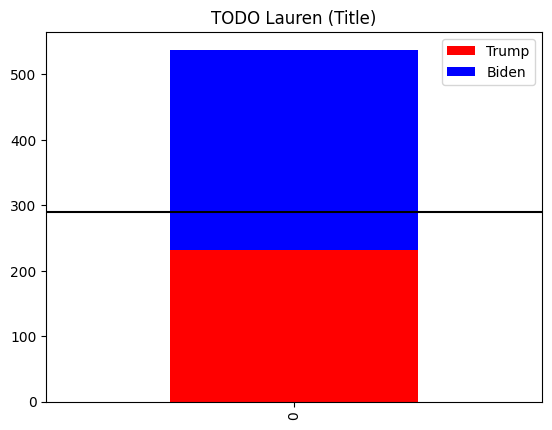

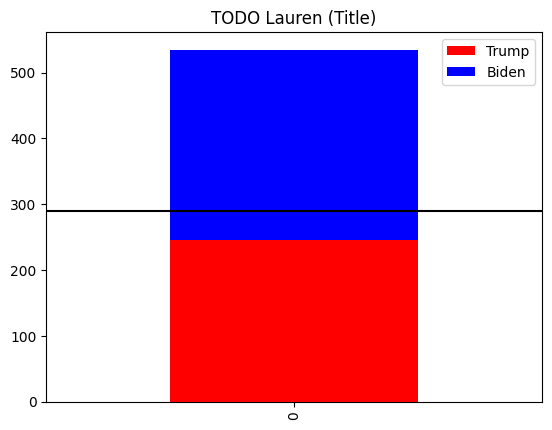

In [139]:
df_trump_real = pd.DataFrame([232], columns=["Trump"])
df_biden_real = pd.DataFrame([306], columns=["Biden"])



ax = df_trump_real.plot.bar(color = 'r')
df_biden_real.plot.bar(color = 'b', bottom = df_trump_real["Trump"], ax=ax)
plt.axhline(pred_biden_votes, color='black')
plt.title("TODO Lauren (Title)")
plt.show()

df_trump_pred = pd.DataFrame([pred_trump_votes], columns=["Trump"])
df_biden_pred = pd.DataFrame([pred_biden_votes], columns=["Biden"])

ax = df_tump_pred.plot.bar(color = 'r')
df_biden_pred.plot.bar(color = 'b', bottom = df_trump_pred["Trump"], ax=ax)
plt.axhline(pred_biden_votes, color='black')
plt.title("TODO Lauren (Title)")

plt.show()